In [25]:
from utils import *
from constants import *
import numpy as np
import json
import os, shutil
import csv
import matplotlib as mpl
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [35]:
# opt = parse()

no = "30"    
origin_path = "data/origin/valid"
result_path = os.path.join("test_results", no)



sitename: 湖口
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 16.18 ± 21.72
predict mean ± std: 18.34 ± 7.33


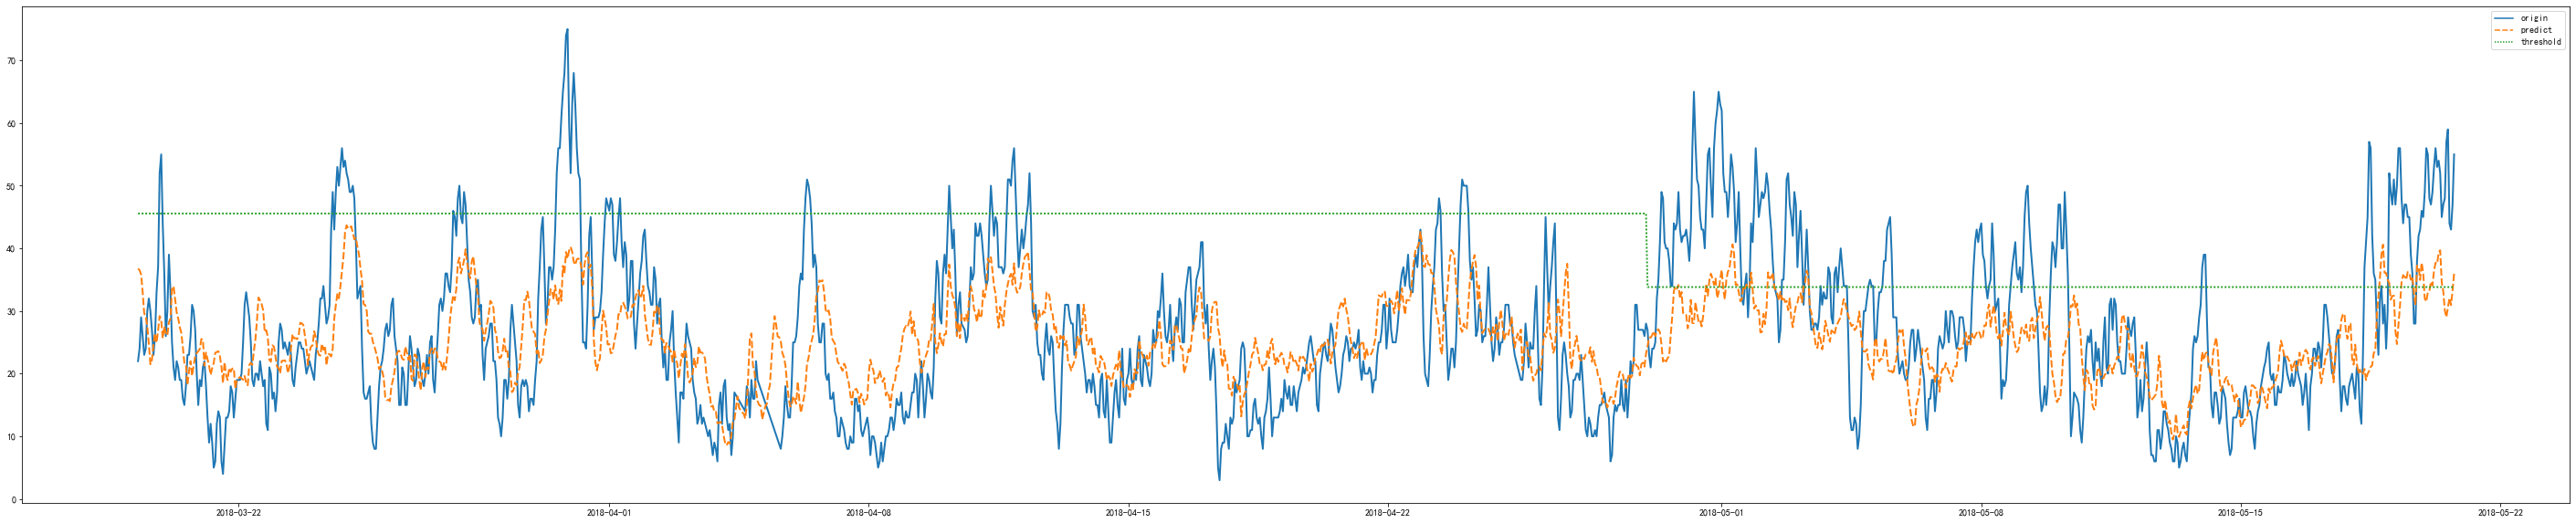

sitename: 林園
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 17.45 ± 24.12
predict mean ± std: 24.91 ± 11.40


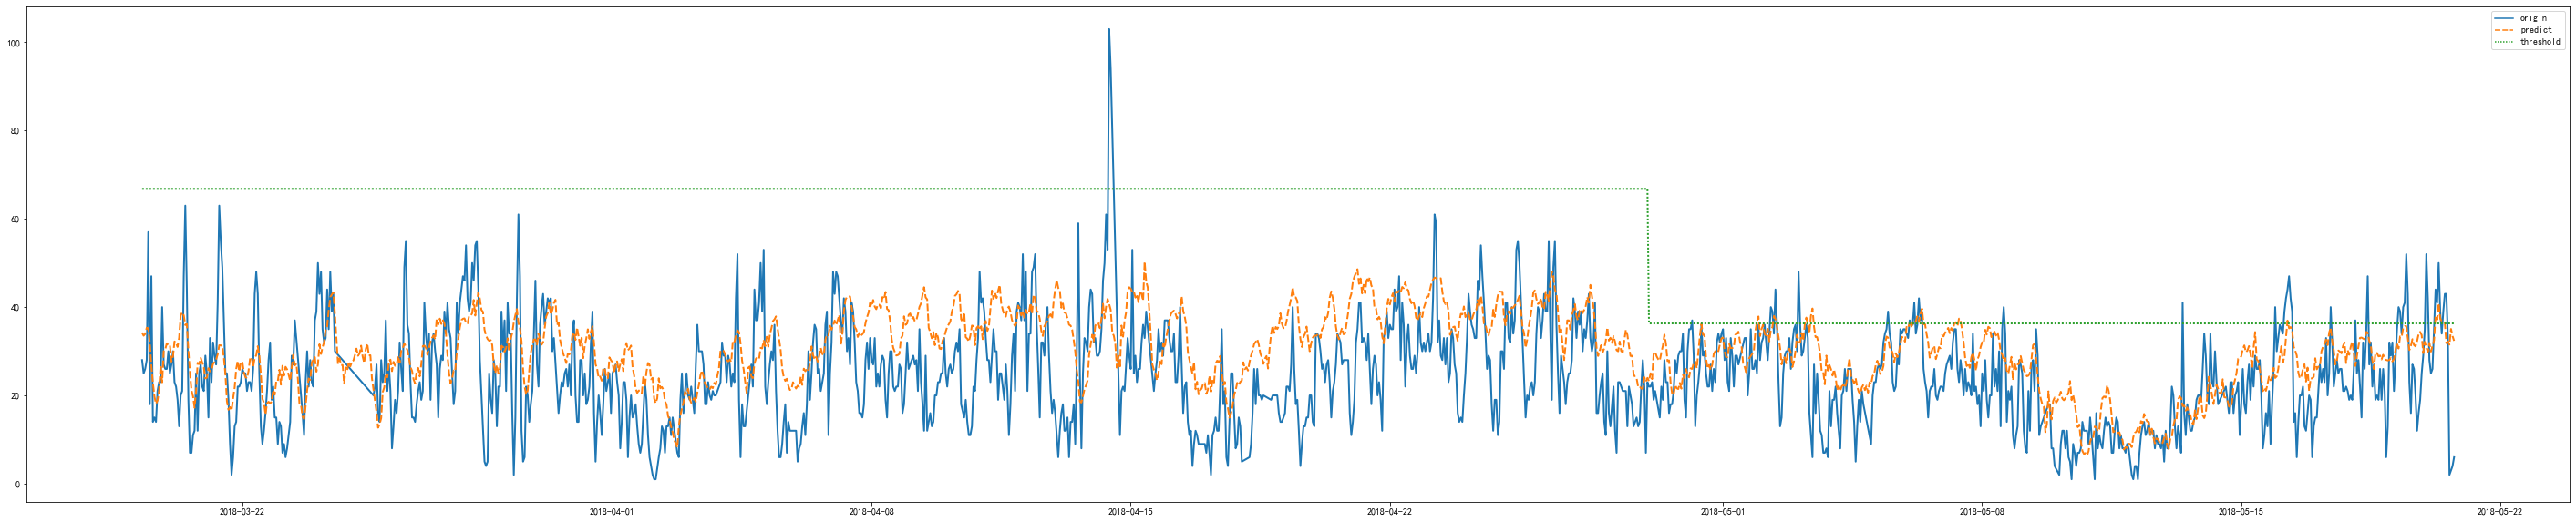

sitename: 南投
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 16.22 ± 21.27
predict mean ± std: 22.63 ± 10.71


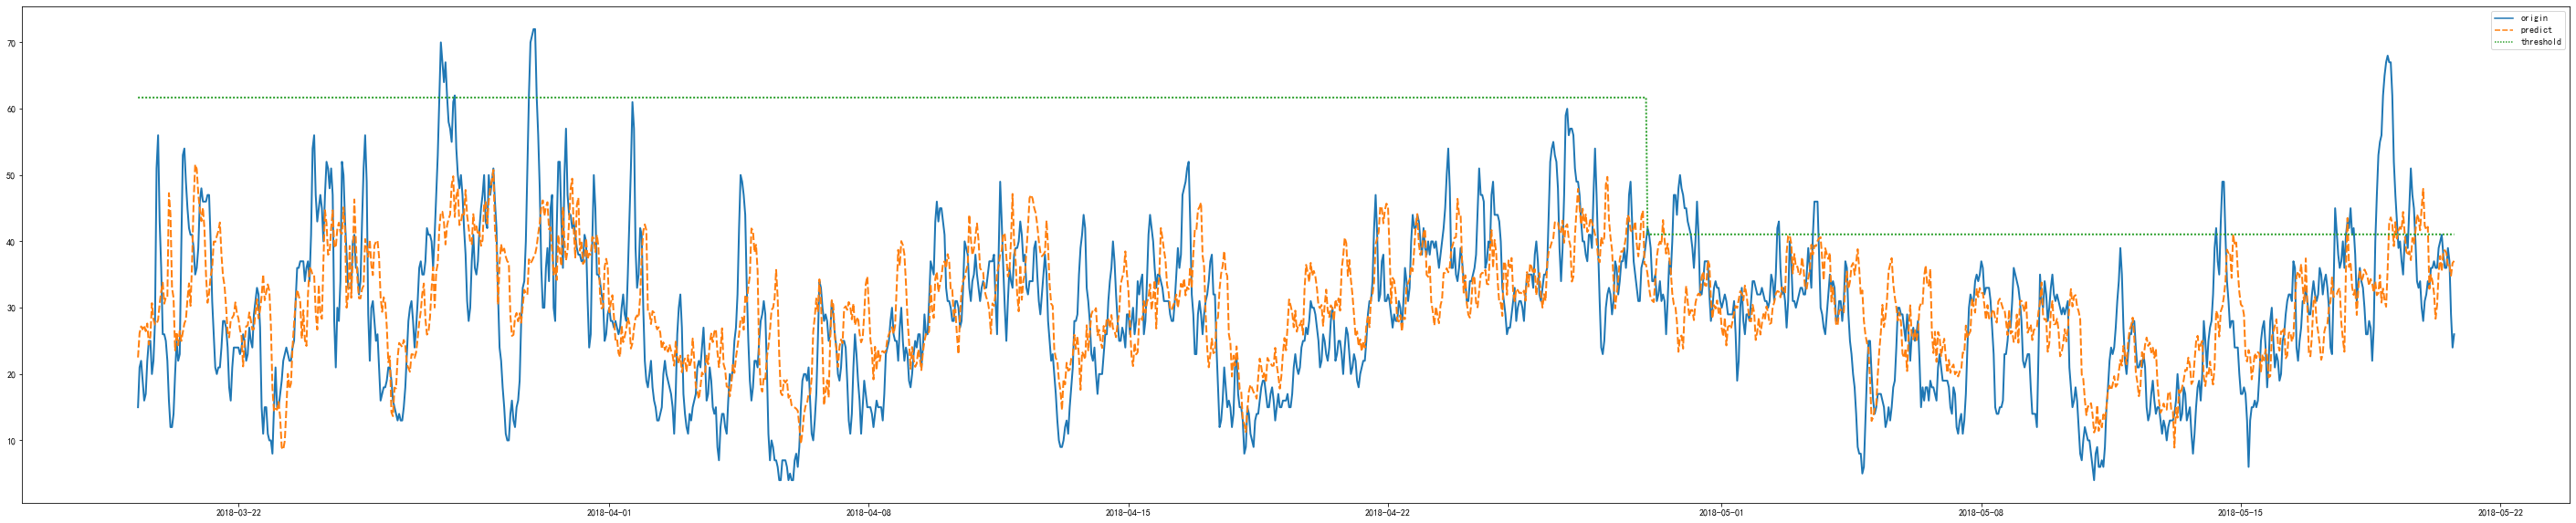

sitename: 士林
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 15.32 ± 20.45
predict mean ± std: 16.58 ± 6.67


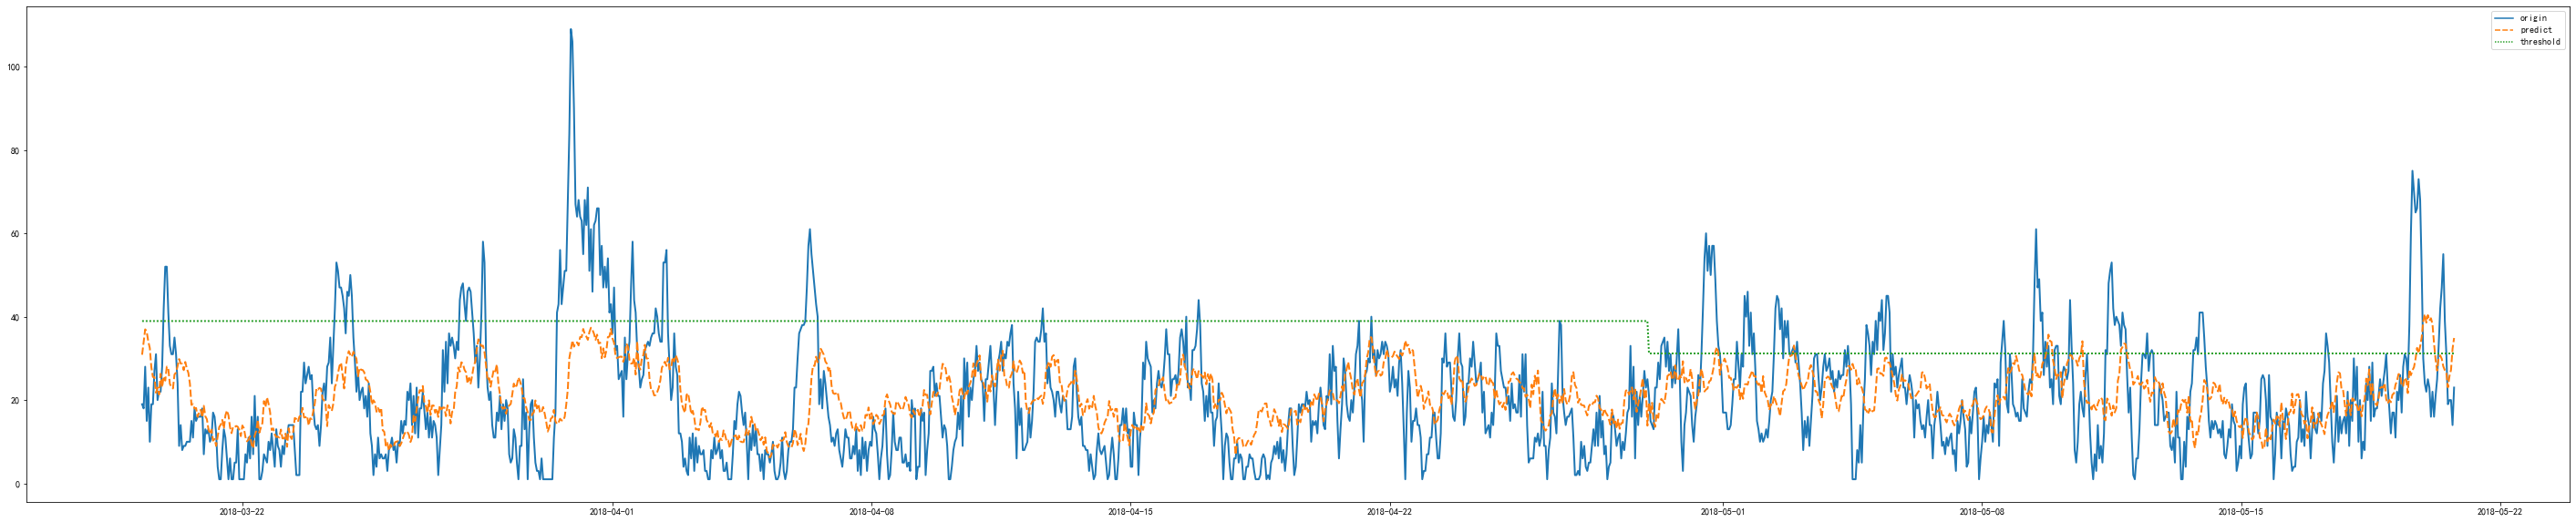

sitename: 埔里
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 15.77 ± 22.04
predict mean ± std: 22.12 ± 8.96


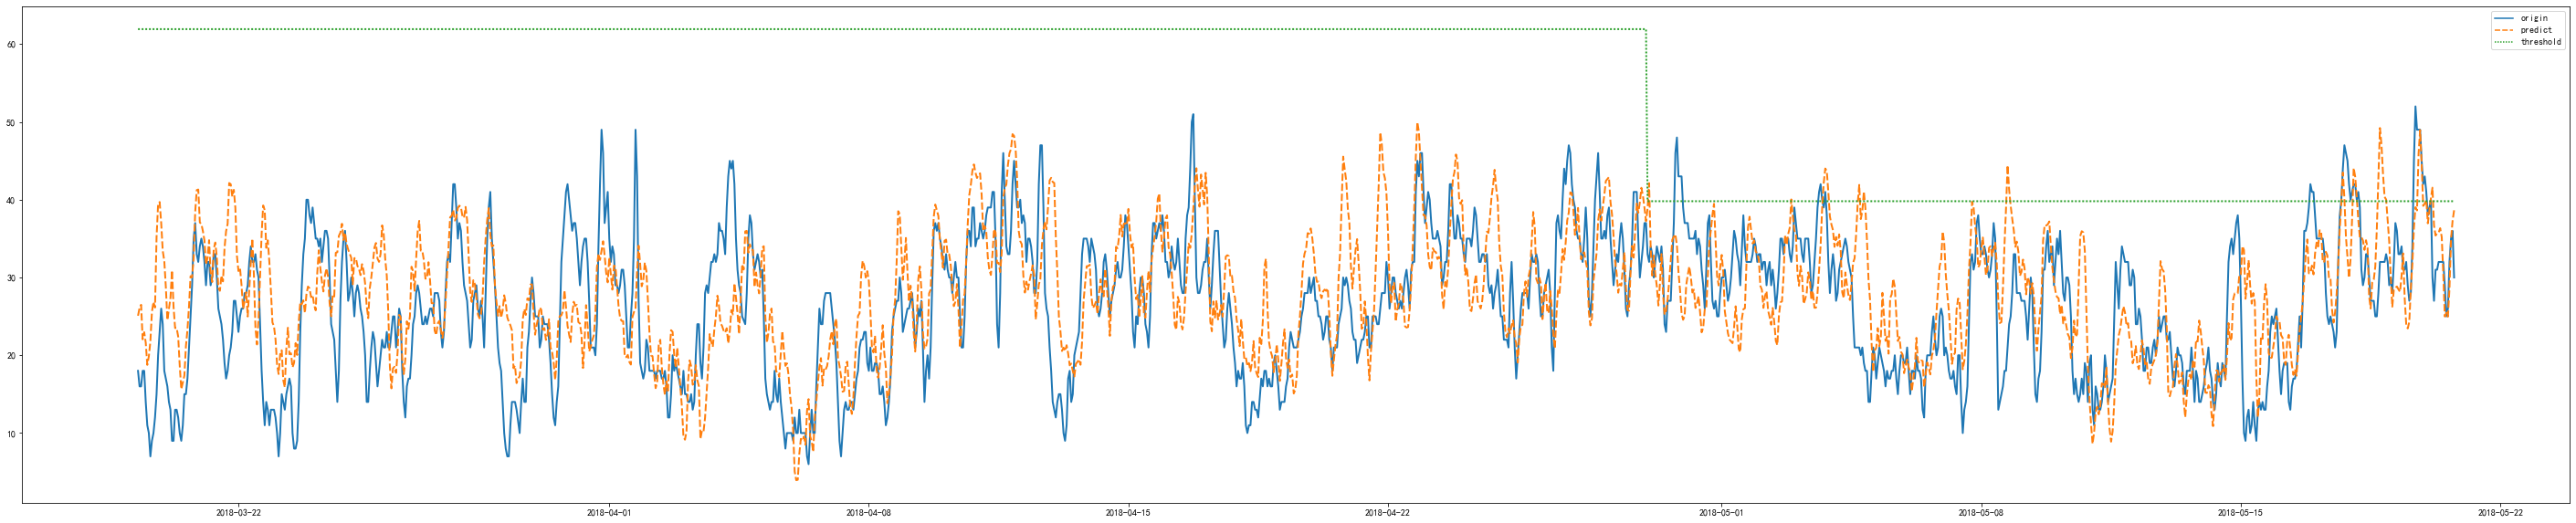

sitename: 關山
(8577, 16) (8577, 1, 1)
[ 1.  8. 15.]
origin  mean ± std: 12.13 ± 20.38
predict mean ± std: 9.36 ± 3.49


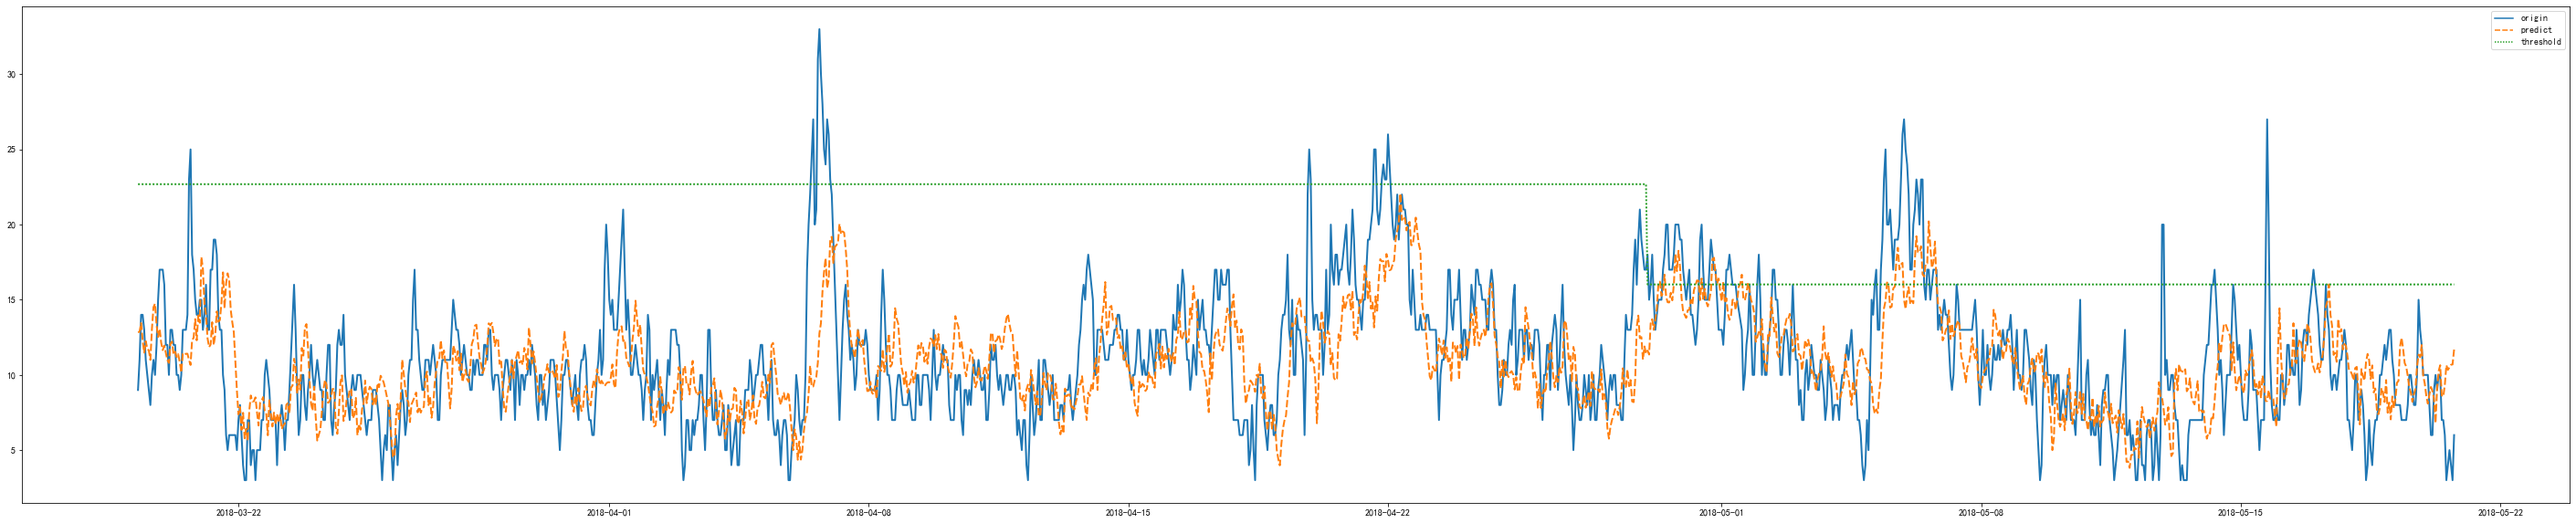

In [36]:

with open("data/train_threshold.json", "r") as fp:
    thres_list = json.load(fp)

for sitename in sample_sites:
    print(f"sitename: {sitename}")
    origin_data = np.load(f"{origin_path}/{sitename}.npy")
    predict_data = np.load(f"{result_path}/{sitename}.npy")
    threshold = thres_list[sitename]

    window_size = 168
    target = 8
    origin_data = origin_data[window_size+8-1+target:]
#     predict_data = np.expand_dims(predict_data, axis=-1)
    # create thres_data
    thres_data = np.zeros((origin_data.shape[0], 1))
    s_index = np.isin(origin_data[:, -3], [4,5,6,7,8,9])
    w_index = np.isin(origin_data[:, -3], [4,5,6,7,8,9], invert=True)
    thres_data[s_index] = threshold["summer"]
    thres_data[w_index] = threshold["winter"]
    print(origin_data.shape, predict_data.shape)
    print(origin_data[0, -3:])
    print(f"origin  mean ± std: {origin_data.mean():.2f} ± {origin_data.std():.2f}")
    print(f"predict mean ± std: {predict_data.mean():.2f} ± {predict_data.std():.2f}")
    st = 1000
    ed = 2500#predict_data.shape[0]
    origin_data  = origin_data [st:ed]
    predict_data = predict_data[st:ed]
    thres_data   = thres_data[st:ed]
    y = np.concatenate((origin_data[:, 7:8], predict_data[:, 0], thres_data), axis=-1)
    
    plt.figure(figsize=(50, 10))
    # TODO: the date should be customized
    st_time = f"2018-{int(origin_data[0][-3]+1)}-{int(origin_data[0][-2])} {int(origin_data[0][-1])}:00:00"
    dates = pd.date_range(st_time, periods=predict_data.shape[0], freq="H")
    data = pd.DataFrame(y, dates, columns=["origin", "predict", "threshold"])
    #sn.set_theme(style="whitegrid")
    plot = sn.lineplot(data=data, palette="tab10", linewidth=2, )
#     plot.set_title(f"{sitename}")
#     plot.figure.savefig(f"{save_path}/{sitename}.png")
    plt.show()
    #break


25.18 121.79


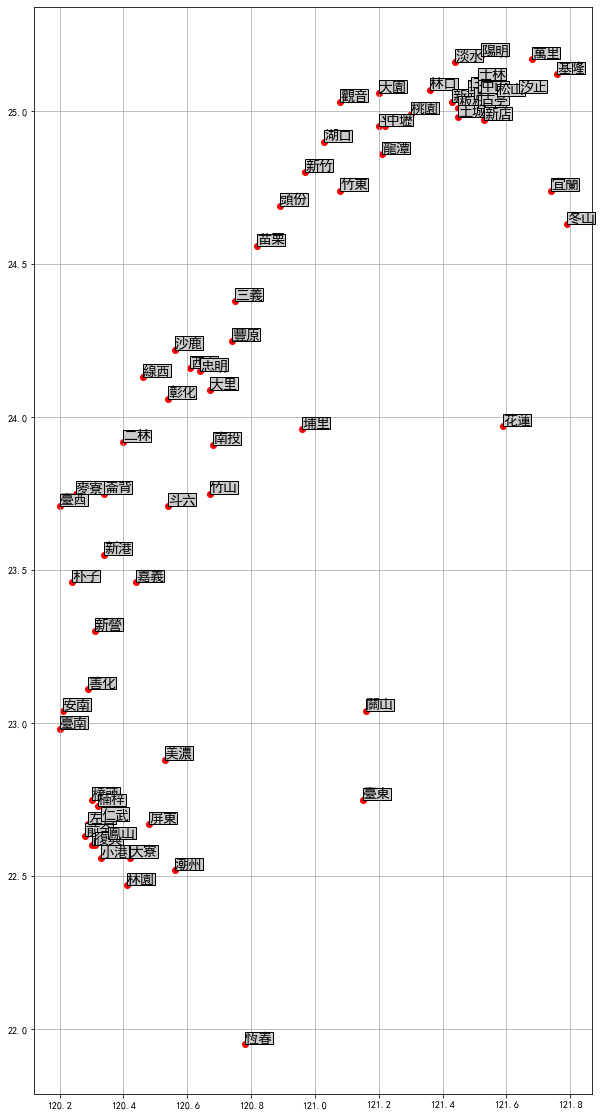

In [24]:
# plot site 2d map by gps

sitenames_sorted = sorted(sitenames)

dataset_files = ['epa_tw_14_direction.csv',
                'epa_tw_15_direction.csv',
                'epa_tw_16_direction.csv',
                'epa_tw_17_direction.csv',
                'epa_tw_18_direction.csv']

dataset_files = [f"data/{x}" for x in dataset_files]

# MARK: - Functions
def read_csv(dataset):
    data = pd.DataFrame()
    if dataset == "train":
        for d in dataset_files[:4]:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    elif dataset == "valid":
        for d in dataset_files[4:]:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    elif dataset == "all":
        for d in dataset_files:
            read_path = os.path.join(d)
            data = data.append(pd.read_csv(read_path, index_col='Unnamed: 0'))
    return data

# MARK: - Main

data = read_csv("valid")
data = data[data.sn.isin(sitenames_sorted)]
# Sort data by read_time and sitename
data = data.sort_values(['read_time', 'sn'])
# Reorder the data
data = data.reset_index(drop=True)
#gps_data = data[:len(sitenames_sorted), ["lat", "lon", "sn"]]
data = data[:len(sitenames_sorted)]
data = data[['sn', 'lat', 'lon']]
data['lat'] = pd.to_numeric(data.lat.apply(lambda x: x.replace("(", "").replace(")", "").split(",")[0]) )
data['lon'] = pd.to_numeric(data.lon.apply(lambda x: x.replace("(", "").replace(")", "").split(",")[0]) )
data = data.sort_values(['lon'], ascending=True)
data = data.to_numpy()
#min_lat = data[:, 1].min()
#min_lon = data[:, 2].min()
#data[:, 1] -= min_lat
#data[:, 2] -= min_lon
#print(data)
print(data[:, 1].max(), data[:, 2].max())

def addtext(ax, x, y, title, props):
    ax.text(x, y, title, props, fontsize=14)
    ax.scatter(x, y, color='r')
    ax.grid(True)

# the text bounding box
bbox = {'fc': '0.8', 'pad': 0}

fig, axs = plt.subplots(1, 1, figsize=(10, 20))

for itm in data:
    x, y = itm[2], itm[1]
    name = itm[0]
    addtext(axs, x, y, name, {'ha': 'left', 'va': 'bottom', 'bbox': bbox})
plt.savefig('map.png')
plt.show()

# "新莊", "板橋", "土城", "士林", "中山", "萬華", "新店", "永和", "淡水", "三重", "陽明", "大同", "松山", "古亭", "菜寮"
# "前金", "左營", "前鎮", "復興", "橋頭", "楠梓", "仁武", "小港", "鳳山"
# "林口", "桃園", "大園", "平鎮", "中壢", "龍潭"
# "苗栗", "頭份", "新竹", "湖口", "觀音", "竹東"